# Labwork 8: Scatter

In [34]:
IMAGE_FILE = "anh.jpg"

## Visualize the image

In [31]:
import matplotlib.pyplot as plt

def show_image(images, titles=None, vmax=255):
  if not isinstance(images, list):
    images = [images, ]

  _images = []
  for image in images:
    if isinstance(image, str):
      image = plt.imread(image)
    _images.append(image)
    height, width, channels = image.shape
    print(f"Size of image: {width} x {height} - {height * width} pixels - channel {channels}")

  columns = len(images)
  fig = plt.figure(figsize=(8*columns, 8))
  for i in range(1, columns +1):
    img = _images[i-1]
    fig.add_subplot(1, columns, i)
    plt.imshow(img, vmin=0, vmax=vmax)
    plt.axis('off')
    plt.title(None if not titles else titles[i-1], fontweight ="bold")
  plt.show()

Size of image: 2048 x 1366 - 2797568 pixels - channel 3


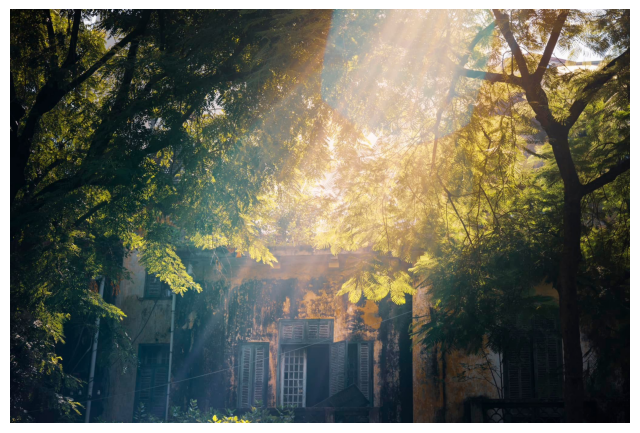

In [36]:
show_image(IMAGE_FILE)

## RGB2HSV

In [40]:
from numba import cuda
import numba
import numpy as np
import time


@cuda.jit
def rgb2hsv(src, dst, h, w):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx >= w or tidy >= h:
    return

  r, g, b = src[tidy, tidx]
  r = np.float32(r) / 255
  g = np.float32(g) / 255
  b = np.float32(b) / 255

  max_val = max(r, max(g, b))
  min_val = min(r, min(g, b))
  delta = max_val - min_val

  v = max_val
  s = 0 if max_val == 0 else np.float32(delta / max_val)
  if delta == 0:
    h = 0
  elif max_val == r:
    h = 60 * ((np.float32(g-b)/delta) % 6)
  elif max_val == g:
    h = 60 * (np.float32(b-r)/delta + 2)
  else:
    h = 60 * (np.float32(r-g)/delta + 4)

  dst[0, tidy, tidx] = h
  dst[1, tidy, tidx] = s
  dst[2, tidy, tidx] = v


def convert_rgb2hsv(img, blockSize=(32, 32)):
  h, w = img.shape[0], img.shape[1]
  gridSize = (
    (w + blockSize[1] - 1) // blockSize[1],
    (h + blockSize[0] - 1) // blockSize[0],
  )

  start_t = time.time()

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((3, h, w), np.float32)

  rgb2hsv[gridSize, blockSize](devSrc, devDst, h, w)
  hsv = devDst.copy_to_host()

  total_time = time.time() - start_t
  print(f"It took {total_time} seconds to finish.")

  return hsv, total_time


## HSV2RGB

In [24]:
from numba import cuda
import numba
import numpy as np
import time


@cuda.jit
def hsv2rgb(src_h, src_s, src_v, dst, h, w):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx >= w or tidy >= h:
    return

  H, S, V = src_h[tidy, tidx], src_s[tidy, tidx], src_v[tidy, tidx]

  d = H/60
  hi = np.uint8(d) % 6
  f = d - hi
  l = V * (1 - S)
  m = V * (1 - f*S)
  n = V * (1 - (1 - f)*S)

  if H < 60:
    r, g, b = V, n, l
  elif H < 120:
    r, g, b = m, V, l
  elif H < 180:
    r, g, b = l, V, n
  elif H < 240:
    r, g, b = l, m, V
  elif H < 300:
    r, g, b = n, l, V
  else:
    r, g, b = V, l, m

  dst[tidy, tidx, 0] = np.uint8(r * 255)
  dst[tidy, tidx, 1] = np.uint8(g * 255)
  dst[tidy, tidx, 2] = np.uint8(b * 255)


def convert_hsv2rgb(hsv, blockSize=(32, 32)):
  h, w = hsv.shape[1], hsv.shape[2]
  gridSize = (
    (w + blockSize[1] - 1) // blockSize[1],
    (h + blockSize[0] - 1) // blockSize[0],
  )

  start_t = time.time()

  devSrc = cuda.to_device(hsv)
  devDst = cuda.device_array((h, w, 3), np.uint8)

  hsv2rgb[gridSize, blockSize](devSrc[0], devSrc[1], devSrc[2], devDst, h, w)
  rgb = devDst.copy_to_host()

  total_time = time.time() - start_t
  print(f"It took {total_time} seconds to finish.")

  return rgb, total_time

## Test function

It took 0.4956181049346924 seconds to finish.
It took 0.01666426658630371 seconds to finish.
Size of image: 2048 x 1366 - 2797568 pixels - channel 3
Size of image: 2048 x 1366 - 2797568 pixels - channel 3


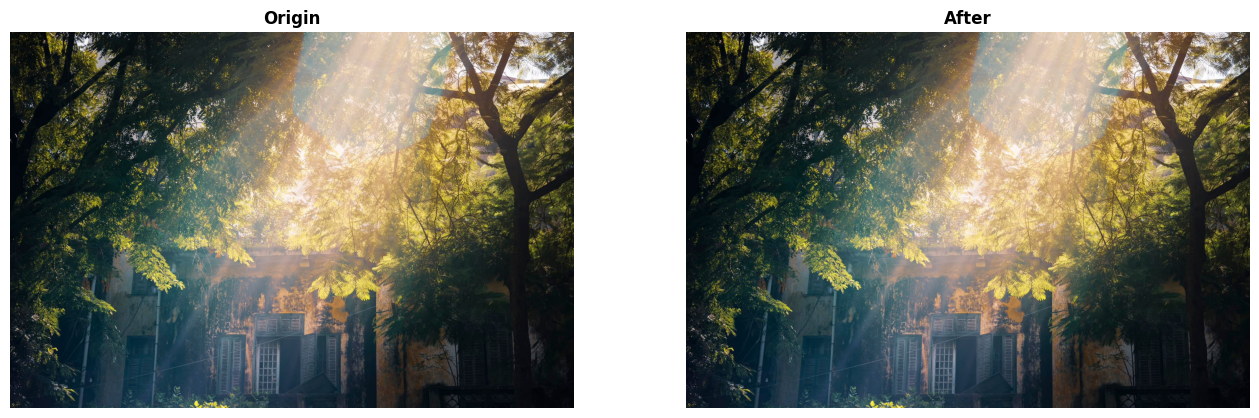

In [41]:
img_rgb_orig = plt.imread(IMAGE_FILE)

hsv_soa, _ = convert_rgb2hsv(img_rgb_orig, (32, 32))
rgb_aos, _ = convert_hsv2rgb(hsv_soa, (32, 32))

show_image([IMAGE_FILE, rgb_aos], titles=["Origin", "After"])